In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

2021.07.06

通过python脚本绘制时间、纬向剖面

前处理部分，将所有降水变量处理问统一的坐标（来自CN05.1）

合并到 var 字典之中，用作后续的绘图

remains：
- 调整色标
- 将时间ticks旋转下

In [2]:
dir_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res_dayofyear/"
filename_cn051  = "ydaymean_mask_sel_CN05.1_Tm_1961_2018_daily_025x025.nc"
# filename_cmorph = "ydaymean_mask_sel_CMORPH_98-17.nc"
filename_vr     = "ydaymean_mask_mean_t2m_98-17_VR.nc"
filename_rcm    = "ydaymean_mask_mean_t2m_98-17_RCM.nc"

ds_or = {}
ds_or['cn051']  = xr.open_dataset(dir_in + filename_cn051)
# ds_or['cmorph'] = xr.open_dataset(dir_in + filename_cmorph)
ds_or['vr']     = xr.open_dataset(dir_in + filename_vr)
ds_or['rcm']    = xr.open_dataset(dir_in + filename_rcm  )
# 提取变量
var = {}
var['cn051'] = ds_or['cn051']['tm']
# var['cmorph'] = ds_or['cmorph']['cmorph'][:, 0, :, :]
var['vr'] = ds_or['vr']['t2m'] - 273.15
var['rcm'] = ds_or['rcm']['t2m'] - 273.15
# change coords
var_list = ['cn051', 'vr', 'rcm']
for i in var_list:
    rename_dict = dict(zip(var[i].coords.keys(), var['cn051'].coords.keys()))
    # show converting coords
    for rename_i in rename_dict:
        print(rename_i + " -----converting to----- " + rename_dict[rename_i])

    var[i] = var[i].rename(rename_dict)
    var[i]._coords = var['cn051']._coords
    var[i] = var[i].rename(i)


time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat


In [3]:
region_dict = {}
lat = var['cn051'].lat
lon = var['cn051'].lon
time= var['cn051'].time
region_dict['lat'] = lat[(lat>=5) & (lat<=60)]
region_dict['lon'] = lon[(lon>=105) & (lon<=125)]
var_lattime = {}
for ivar in var.keys():
    var_lattime[ivar] = var[ivar].sel(region_dict).mean('lon')

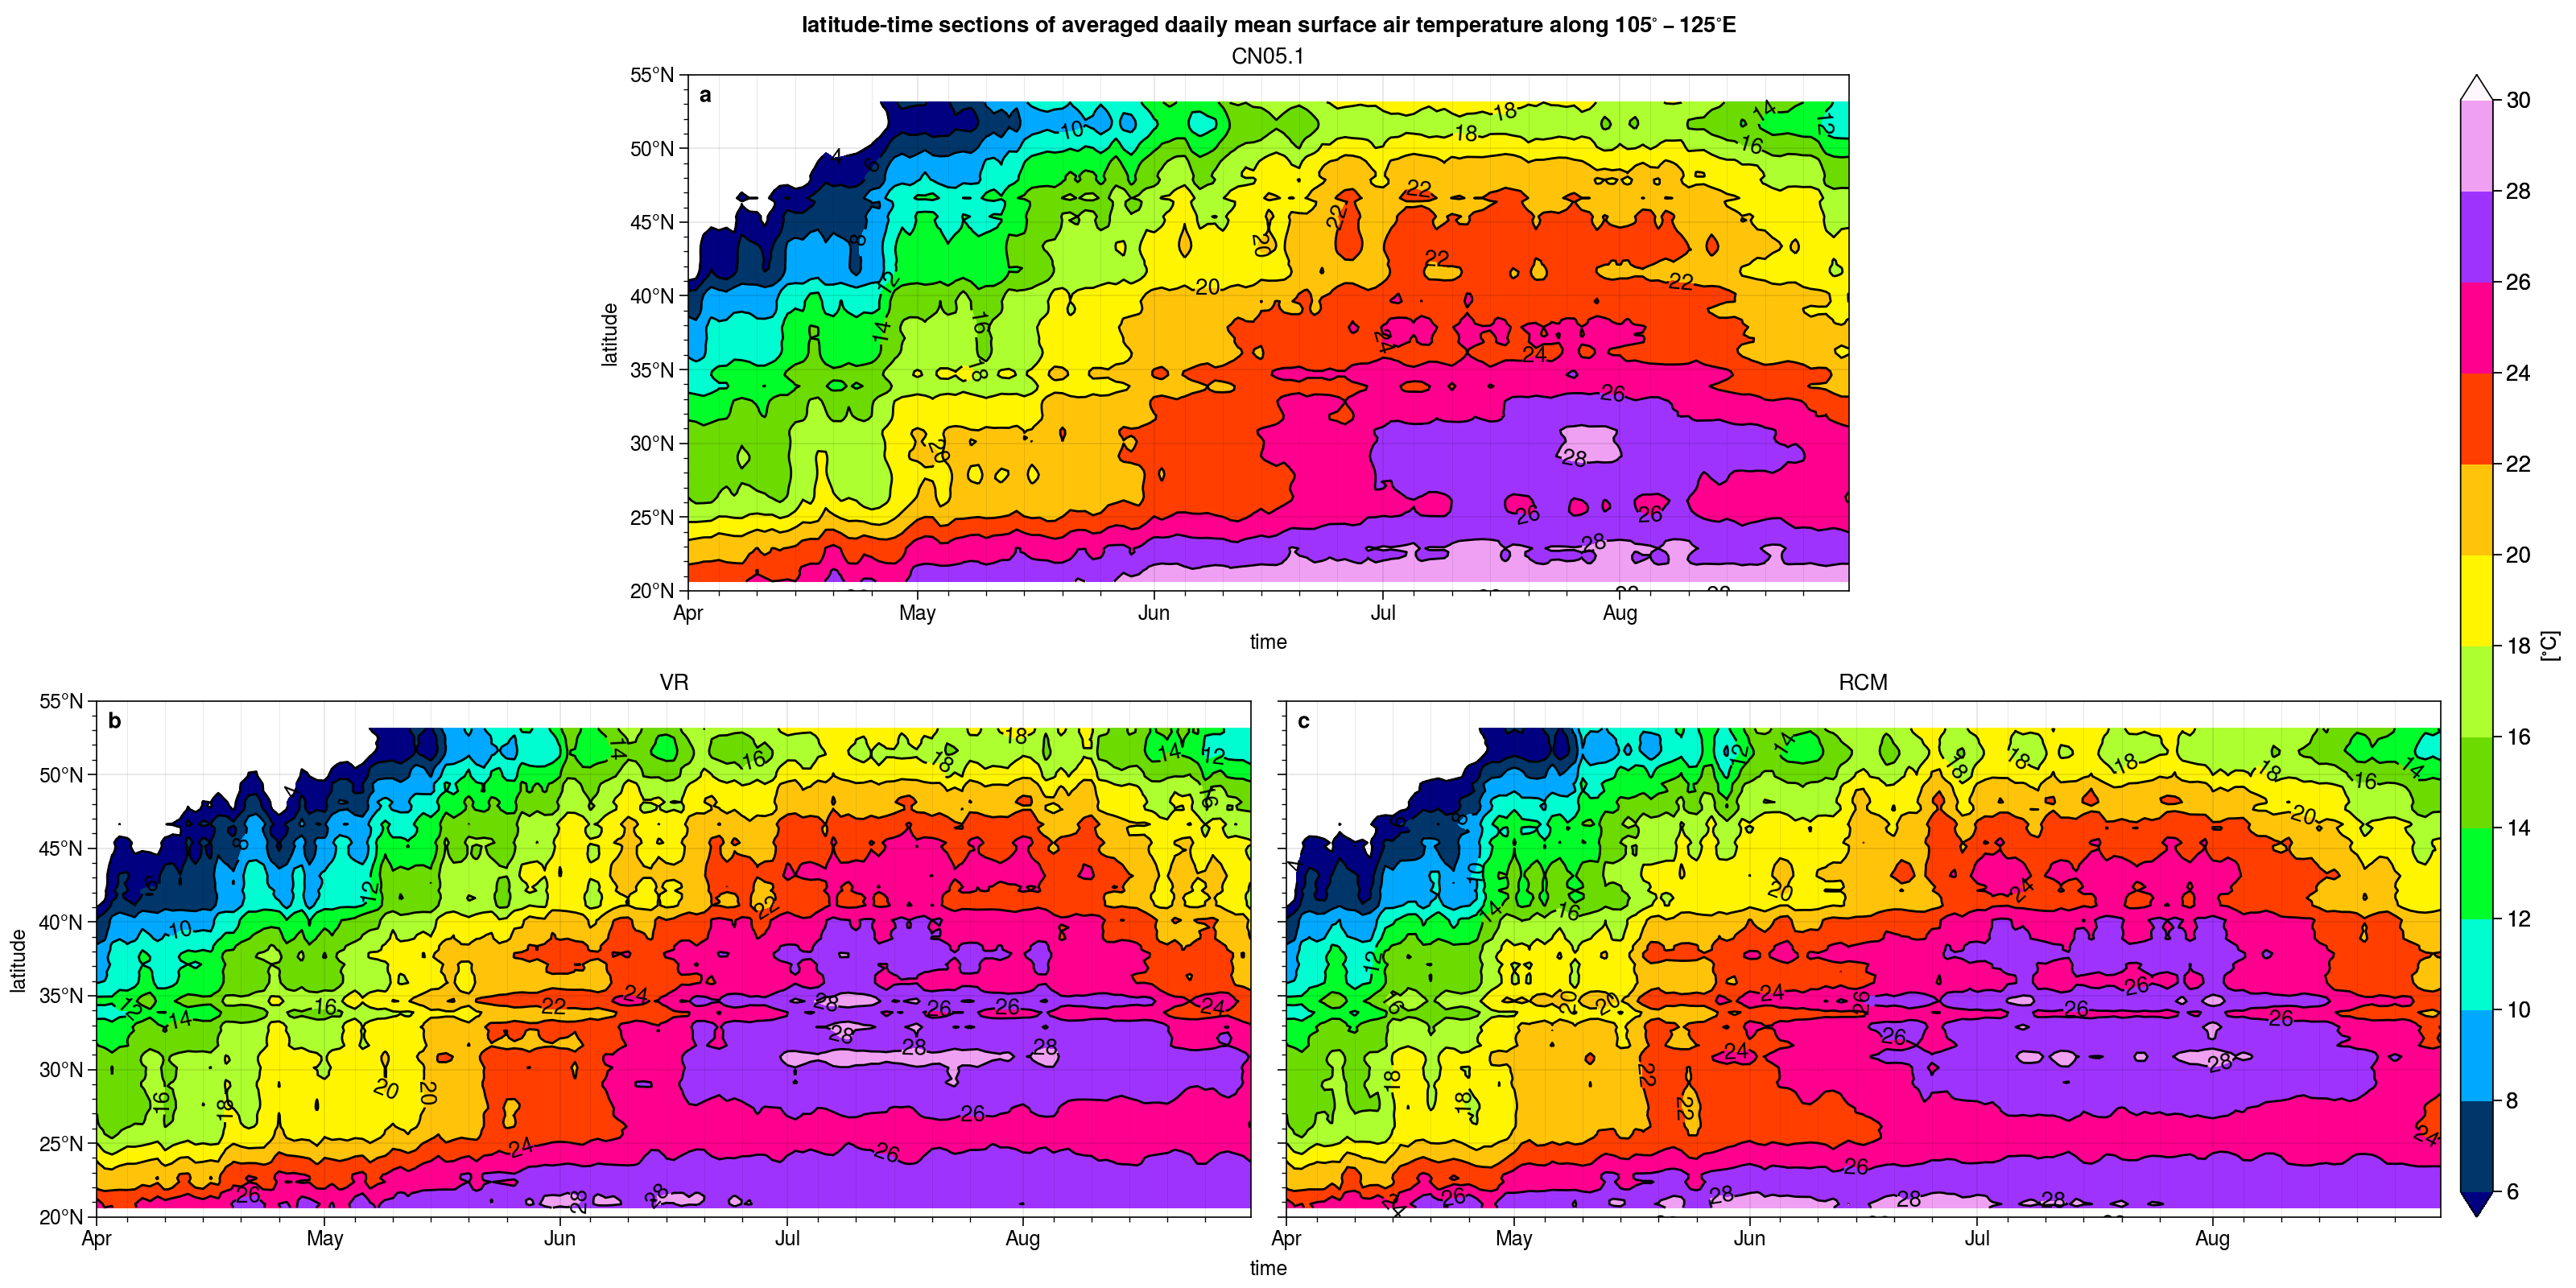

In [8]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
# ----- get filter vars coords-----

cmap="gist_ncar"
# cmap="tab20"

lat_sel  = var_lattime['cn051'].lat
# time_sel = var_lattime['cn051'].time.dt.strftime("%m-%d")
time_sel = var_lattime['cn051'].time.values

ticks = np.arange(4,34,2.)
ticks_contour = np.arange(4,34,2.)
#----- create plot -----
shapearray=[[0,1,1,0],[2,2,3,3]]
fig, axs = plot.subplots(shapearray,figsize=(16,8))

#-----2012-----
axs[0].format(title='CN05.1')
# axs[1].format(title='CMORPH')
axs[1].format(title='VR')
axs[2].format(title='RCM')
# m = axs[0].contour(lon_sel, time_sel, var_lattime['cn051'],\
# levels=ticks,color='k',
# linewidth = .5)
for i, ivar in enumerate(var_list):
    m_overlay = axs[i].contourf(time_sel,  lat_sel, var_lattime[ivar].values.T, cmap=cmap,\
    levels=ticks)
    m_contour = axs[i].contour(time_sel,  lat_sel, var_lattime[ivar].values.T,\
    levels=ticks_contour,linewidth=1,color='k')
    axs[i].clabel(m_contour, inline=True, fontsize=10, colors = 'k', fmt='%2.0f',use_clabeltext=True, inline_spacing=0)
# format作为整个proplot集中对属性进行修改的method
axs.format(

abc=True, abcloc='ul',

yformatter='deglat',
ylim=(20,55),
ylabel='latitude',

# xlocator='weekday',
# xlocator=('month', [4,5,6,7,8]),
# xminorlocator='day',
# xformatter='%m-%d',
xrotation=0,  # rotated time ticks
xlabel='time',
xminorlocator=('day',range(0,30,5)),
xlocator=('month',range(0,12,1)),
xformatter = '%b', #title='Ticks every N units',
xgridminor = True,

suptitle="latitude-time sections of averaged daaily mean surface air temperature along " + r"$105^{\circ} -125^{\circ} E$"
)

# for tick in axs.get_xticklabels():
    # tick.set_rotation(45)
#----- add contour tick labels -----
fig.colorbar(m_overlay, loc='r', length = 1., width=0.2,extend='both', label= "[" + r'$^{\circ} C$' + "]",
ticklabelsize=10,ticks=ticks)

fig.patch.set_facecolor('white')
plt.savefig('./output_pic/t2m_98-17_lat-time_py_0918.png', dpi=600, facecolor= "white")